In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/scripts"))
import auxiliar as aux
import geometry as geom

# Configuration and paths

In [2]:
# Source specifications
source_name = "crab"

# Run number
run_bad  = 6172
run_good = 3270

In [3]:
# Root path of this script
root = "/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/dl2_production/"
# Data main directory
root_data = root + f"../../data/cosmic_ray_data_correction/{source_name}/"

# directories for the data
dir_dl1b = root_data + "dl1b/"
dir_dl2  = root_data + "dl2/"

# Read datacheck data

In [4]:
dcheck_good = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20201215.h5"
dcheck_bad  = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20210908.h5"

dcheck_good = pd.read_hdf(dcheck_good, key="cosmics_intensity_spectrum").query(f"runnumber == {run_good}")
dcheck_bad  = pd.read_hdf(dcheck_bad,  key="cosmics_intensity_spectrum").query(f"runnumber == {run_bad}")
dcheck_good[:4]

,yyyymmdd,ra_tel,dec_tel,cos_zenith,az_tel,runnumber,subrun,time,elapsed_time,corrected_elapsed_time,delta_t_exp_index,cosmics_rate,cosmics_cleaned_rate,intensity_at_half_peak_rate,intensity_at_peak_rate,ZD_corrected_intensity_at_half_peak_rate,cosmics_peak_rate,ZD_corrected_cosmics_peak_rate,cosmics_rate_at_422_pe,delta_cosmics_rate_at_422_pe,ZD_corrected_cosmics_rate_at_422_pe,ZD_corrected_delta_cosmics_rate_at_422_pe,cosmics_spectral_index,delta_cosmics_spectral_index,ZD_corrected_cosmics_spectral_index,intensity_spectrum_fit_p_value,intensity_at_reference_rate,light_yield,diffuse_nsb_std,num_star_affected_pixels,anomalous_low_intensity_peak
568,20201215,83.264558,21.787625,0.859349,1.664841,3270,0,1.608073e+09,10.776082,10.776082,5195.124057,4726.485813,4097.871459,44.467226,66.940365,43.408896,28.844706,37.966819,1.647863,0.023303,1.785560,0.025250,-2.260128,0.086991,-2.209210,0.469526,426.966221,1.021605,1.773901,120,False
569,20201215,83.266563,21.787694,0.859685,1.665306,3270,1,1.608073e+09,10.856308,10.856308,5285.489642,4689.623978,4066.115479,45.242468,66.940365,44.168936,28.763404,37.841589,1.619586,0.015416,1.754496,0.016701,-2.337725,0.058057,-2.286945,0.768944,423.533675,1.006467,1.774722,120,False
570,20201215,83.264628,21.787404,0.860052,1.665827,3270,2,1.608073e+09,10.879756,10.879756,5225.465917,4679.516618,4073.528775,45.766791,66.940365,44.684354,28.439886,37.395726,1.634921,0.033413,1.770641,0.036187,-2.311151,0.125410,-2.260521,0.151818,425.271485,1.013945,1.773967,121,False
571,20201215,83.260643,21.787750,0.860436,1.666351,3270,3,1.608073e+09,10.839594,10.839594,5137.371244,4696.670319,4079.765302,44.724152,74.684021,43.669687,28.882980,37.952988,1.594936,0.022572,1.726861,0.024439,-2.388429,0.085416,-2.337957,0.482166,420.634096,0.994351,1.773526,122,False


# Read dl2 data for all subruns available

In [78]:
run_dirs = [name for name in os.listdir(dir_dl2) if os.path.isdir(os.path.join(dir_dl2, name))]

DICTS = []

for rundir in run_dirs:
    dir_dl2_run = dir_dl2 + rundir
    
    files = glob.glob(dir_dl2_run + "/*")
    
    sruns = np.unique([int(f.split(".")[-3][:-3]) for f in files])
    
    for srun in sruns:
        dir_dl2_srun = dir_dl2_run + f"/*.{srun:04}_*"
        files_srun = glob.glob(dir_dl2_srun)
        
        _dict = {
            "run" : int(rundir),
            "srun" : srun, 
            "scale" : {},
        }
        
        for f in files_srun:
            
            scale = float(f.split("_s")[-1].split(".h5")[0])
            
            _dict["scale"][scale] = pd.read_hdf(f, key="dl2/event/telescope/parameters/LST_LSTCam")
            
        DICTS.append(_dict)

In [82]:
DICT["scale"].keys()

dict_keys([1.5144, 1.3894, 1.6644, 1.481, 1.2977, 1.1144, 1.206, 1.5727, 1.0])

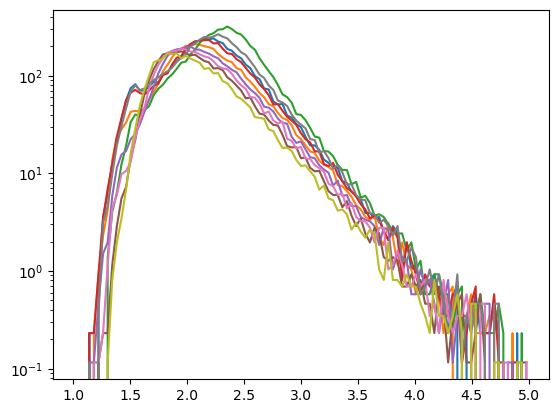

In [86]:
bins = np.linspace(1,5,100)
bins_c = bins[:-1] / 2 + bins[1:] / 2

histograms = []
for DICT in DICTS[1:2]:
    
    for sc in DICT["scale"].keys():
        hist, _  = np.histogram(DICT["scale"][sc]["log_intensity"], bins)
        telapsed = DICT["scale"][sc]["dragon_time"].iloc[-1] - DICT["scale"][sc]["dragon_time"].iloc[0]
        counts = hist / telapsed
    
        plt.plot(bins_c, counts)
plt.yscale("log")

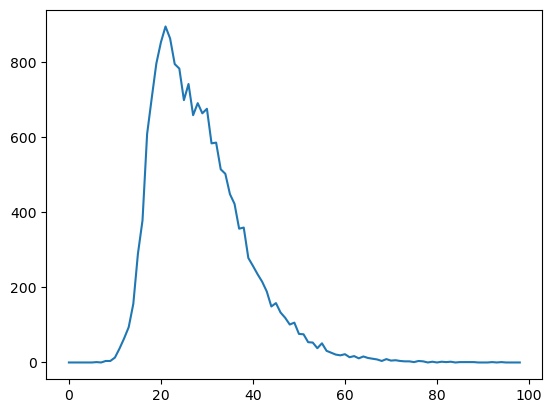

In [5]:
tables = []
for srun in [0,1,2,3]:
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_bad:05}.{srun:04}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 
    tables.append(table)

tables_good = []
for srun in [0]:
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_good:05}.{srun:04}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 
    tables_good.append(table)

## Calculate the rates and save the histogams and other data of each subrun

In [6]:
bins = np.linspace(1,5,100)
bins_c = bins[:-1] / 2 + bins[1:] / 2

histograms_good = []
histograms_bad  = []
zds_good, azs_good = [], []
zds_bad, azs_bad   = [], []
for srun, tab in enumerate(tables):
    tsrun_datacheck = dcheck_bad.query(f"subrun == {srun}")
    counts, bin_edges = np.histogram(tab["log_intensity"], bins=bins)
    rates = counts / float(tsrun_datacheck["corrected_elapsed_time"].iloc[0])
    histograms_bad.append(rates)
    
    coszd = tsrun_datacheck["cos_zenith"].iloc[0]
    zds_bad.append(np.rad2deg(np.arccos(coszd)))
    azs_bad.append(tsrun_datacheck["az_tel"].iloc[0])

for srun, tab in enumerate(tables_good):
    tsrun_datacheck = dcheck_good.query(f"subrun == {srun}")
    counts, bin_edges = np.histogram(tab["log_intensity"], bins=bins)
    rates = counts / float(tsrun_datacheck["corrected_elapsed_time"].iloc[0])
    histograms_good.append(rates)
    
    coszd = tsrun_datacheck["cos_zenith"].iloc[0]
    zds_good.append(np.rad2deg(np.arccos(coszd)))
    azs_good.append(tsrun_datacheck["az_tel"].iloc[0])


## Plot the cosmics rates

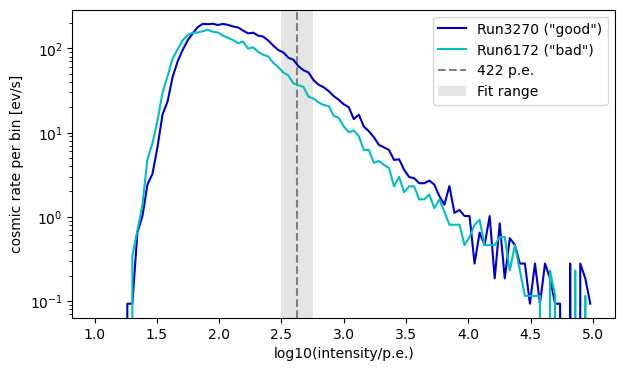

In [7]:
fig, (ax) = plt.subplots(figsize=(7,4))

for srun, tab in enumerate(tables_good):
    ax.plot(bins_c, histograms_good[srun], color="mediumblue", label=f"Run{run_good} (\"good\")" if srun == 0 else "")
    
for srun, tab in enumerate(tables[:1]):
    ax.plot(bins_c, histograms_bad[srun], color="c", label=f"Run{run_bad} (\"bad\")" if srun == 0 else "")

ax.axvline(np.log10(422), color="gray", ls="--", zorder=-1, label="422 p.e.")
ax.axvspan(np.log10(316), np.log10(562), color="gray", alpha=0.2, zorder=-2, label="Fit range", lw=0)

ax.set_yscale("log")
ax.legend()
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("log10(intensity/p.e.)")

plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

RATIO = 1.6383


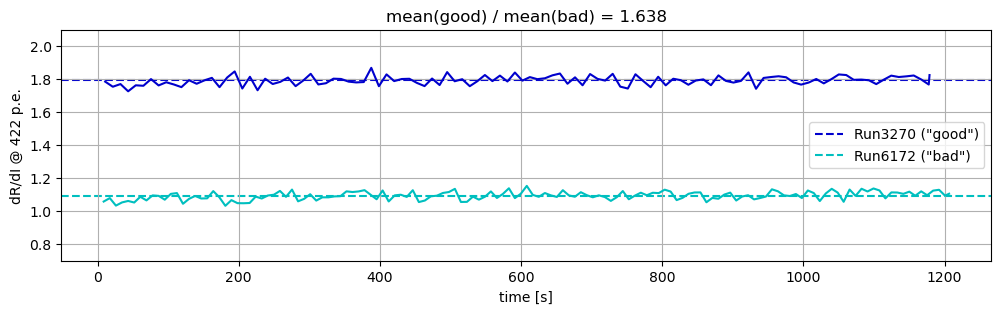

In [8]:
rate_good = np.array(dcheck_good["ZD_corrected_cosmics_rate_at_422_pe"])
rate_bad  = np.array(dcheck_bad["ZD_corrected_cosmics_rate_at_422_pe"])
elpt_good, elpt_bad = np.cumsum(dcheck_good["elapsed_time"]), np.cumsum(dcheck_bad["elapsed_time"])
ratio = np.mean(rate_good)/np.mean(rate_bad)

print(f"RATIO = {ratio:.4f}")

fig, (ax) = plt.subplots(figsize=(12,3))

ax.plot(elpt_bad, rate_bad, color="c")
ax.plot(elpt_good, rate_good, color="mediumblue")
ax.axhline(np.mean(rate_good), ls="--", zorder=-3, color="mediumblue", label=f"Run{run_good} (\"good\")")
ax.axhline(np.mean(rate_bad), ls="--", zorder=-3, color="c", label=f"Run{run_bad} (\"bad\")")

ax.legend(loc=7)
ax.set_ylabel("dR/dI @ 422 p.e.")
ax.set_xlabel("time [s]")
ax.set_ylim(0.7, 2.1)
ax.grid()
ax.set_title(f"mean(good) / mean(bad) = {ratio:.3f}")

plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
print([*np.linspace(1-0.6383, 1, 5)[:-1], *np.linspace(1, 1.6383, 5),*np.linspace(1.6383, 2, 5)[1:]])

[0.3617, 0.521275, 0.68085, 0.840425, 1.0, 1.159575, 1.31915, 1.478725, 1.6383, 1.728725, 1.81915, 1.909575, 2.0]


In [10]:
histograms = []
hist_npix  = []
bins_n = np.linspace(2, 1855, 1855-2)
scales = [0.3617, 0.521275, 0.68085, 0.840425, 1.0, 1.159575, 1.31915, 1.478725, 1.6383, 1.728725, 1.81915, 1.909575, 2]
for scale in scales:
    ext = f"_scaled{scale:.4f}" if scale != 1.0 else ""
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_bad:05}.{0:04}{ext}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 

    datacheck = dcheck_bad.query(f"subrun == 0")
    counts, bin_edges = np.histogram(table["log_intensity"], bins=bins)
    rates = counts / float(datacheck["corrected_elapsed_time"].iloc[0])

    counts_npix, _ = np.histogram(table["n_pixels"], bins=bins_n)
    rates_npix = counts_npix / float(datacheck["corrected_elapsed_time"].iloc[0])
    
    histograms.append(rates)
    hist_npix.append(rates_npix)
    
hist_good_npix, _ = np.histogram(tables[0]["n_pixels"], bins=bins_n)

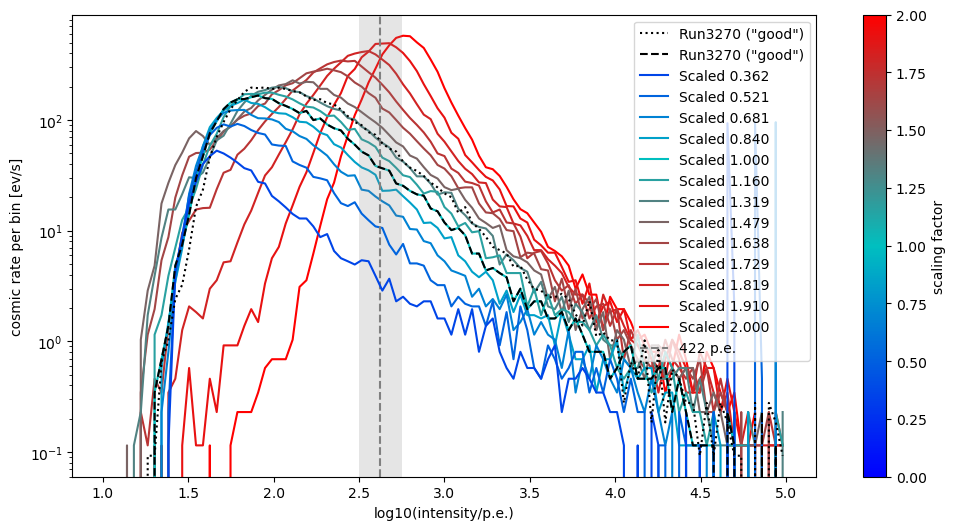

In [11]:
fig, (ax) = plt.subplots(figsize=(12,6))

ax.plot(bins_c, histograms_good[0], color="k", ls=":", label=f"Run{run_good} (\"good\")", zorder=100)
ax.plot(bins_c, histograms[4], color="k", ls="--", label=f"Run{run_good} (\"good\")" if srun == 0 else "", zorder=100)

pcols = ["b", "c", "r"]
colors = aux.get_colors_multiplot(scales, COLORS=pcols, ran=[0, 2])
cmap   = aux.create_cmap(pcols)
aux.plot_colorbar(fig, ax, [0, 2], cmap, label="scaling factor")

for i, scale in enumerate(scales):
    label = f"Scaled {scale:.3f}"
    kw = dict()
    ax.plot(bins_c, histograms[i], color=colors[i], label=label, zorder=-i, **kw)

ax.axvline(np.log10(422), color="gray", ls="--", zorder=-1, label="422 p.e.")
ax.axvspan(np.log10(316), np.log10(562), color="gray", alpha=0.2, zorder=-2, lw=0)

ax.set_yscale("log")
ax.legend()
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("log10(intensity/p.e.)")

# plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

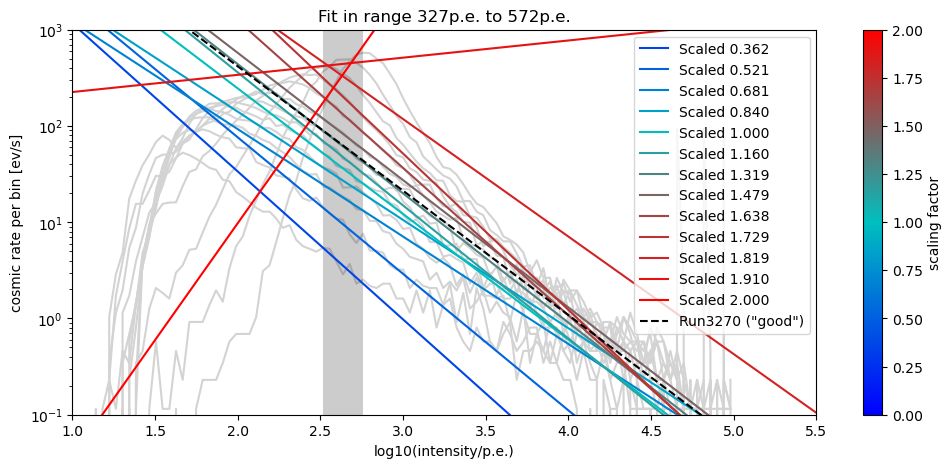

In [12]:
binlims = [37, 44]

fig, (ax) = plt.subplots(figsize=(12,5))


for i, scale in enumerate(scales):
    ax.plot(bins_c, histograms[i], color="lightgray",zorder=-100,)
    
    
pcols = ["b", "c", "r"]
colors = aux.get_colors_multiplot(scales, COLORS=pcols, ran=[0, 2])
cmap   = aux.create_cmap(pcols)
aux.plot_colorbar(fig, ax, [0, 2], cmap, label="scaling factor")


slopes = []
intercepts = []
for i, scale in enumerate(scales):
    
    x = bins_c[binlims[0]:binlims[1]]
    y = histograms[i][binlims[0]:binlims[1]]
    
    fit = np.poly1d(np.polyfit(x, np.log10(y), 1)) 
    
    slopes.append(fit[0])
    intercepts.append(fit(np.log10(422)))
        
    xx = np.linspace(0, 6)
    ax.plot(xx, 10**fit(xx), color=colors[i], label = f"Scaled {scale:.3f}")
    
fitgood = np.poly1d(np.polyfit(x, np.log10(histograms_good[0][binlims[0]:binlims[1]]), 1)) 
slopesgood = fitgood[0]
interceptsgood = fitgood(np.log10(422))


ax.plot(xx, 10**fitgood(xx), color="k", ls="--", label=f"Run{run_good} (\"good\")")
ax.axvspan(bins_c[binlims[0]:binlims[1]][0], bins_c[binlims[0]:binlims[1]][-1], color="k", alpha=0.2, ls="")

ax.set_yscale("log")
ax.legend()
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("log10(intensity/p.e.)")
ax.set_ylim(1e-1, 1e3)
ax.set_xlim(1,5.5)
ax.set_title(f"Fit in range {10**bins_c[binlims[0]:binlims[1]][0]:.0f}p.e. to {10**bins_c[binlims[0]:binlims[1]][-1]:.0f}p.e.")

plt.show()

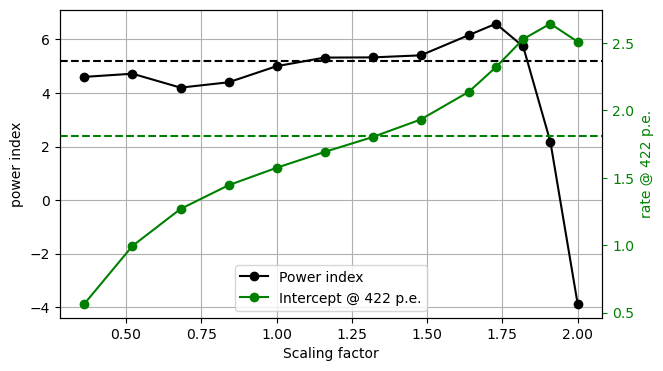

In [13]:
fig, (ax) = plt.subplots(figsize=(7,4))
axt = ax.twinx()

p1, = ax.plot(scales, slopes, color="k", marker="o", label="Power index")
p2, = axt.plot(scales, intercepts, color="g", marker="o", label="Power index")
ax.plot([], [], color="g", marker="o", label="Intercept @ 422 p.e.")
ax.axhline(slopesgood, color="k", ls="--")
ax.plot([], [], color="g", ls="--")
axt.axhline(interceptsgood, color="g", ls="--")

ax.legend(loc=8)
ax.set_ylabel("power index")
axt.set_ylabel("rate @ 422 p.e.")
ax.set_xlabel("Scaling factor")
ax.grid()
ax.yaxis.label.set_color(p1.get_color())
ax.tick_params(axis='y', colors=p1.get_color())
axt.yaxis.label.set_color(p2.get_color())
axt.tick_params(axis='y', colors=p2.get_color())

# plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

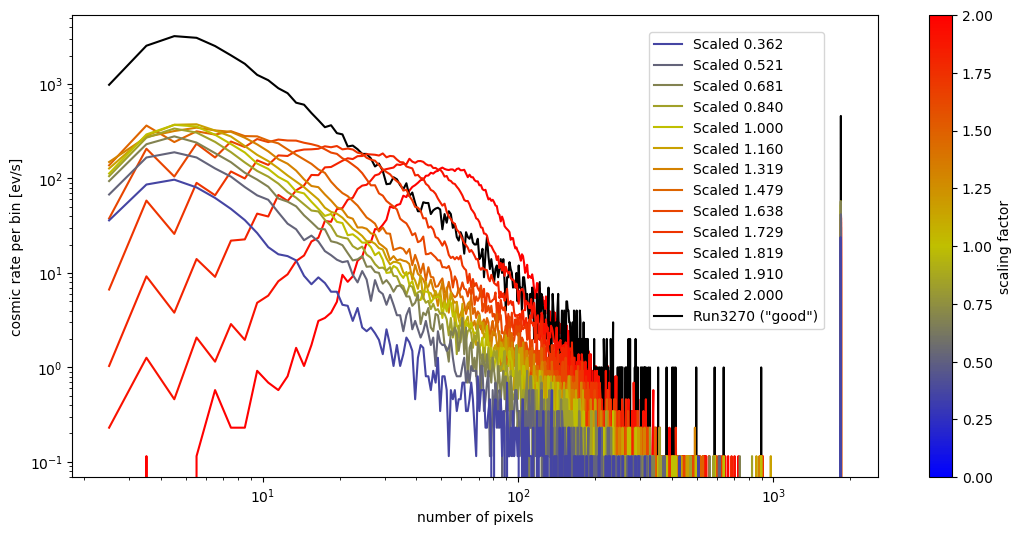

In [14]:
fig, (ax) = plt.subplots(figsize=(13,6))

pcols = ["b", "y", "r"]
colors = aux.get_colors_multiplot(scales, COLORS=pcols, ran=[0, 2])
cmap   = aux.create_cmap(pcols)
aux.plot_colorbar(fig, ax, [0, 2], cmap, label="scaling factor")

for i, scale in enumerate(scales):
    ax.plot(bins_n[1:]/2+bins_n[:-1]/2, hist_npix[i], color=colors[i], label=f"Scaled {scale:.3f}", zorder=-i,)

ax.plot(bins_n[1:]/2+bins_n[:-1]/2, hist_good_npix, color="k", zorder=-i, label=f"Run{run_good} (\"good\")")

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(0, 250)
ax.legend(loc=(0.715, 0.32))
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("number of pixels")

# plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

(0.0, 70.0)

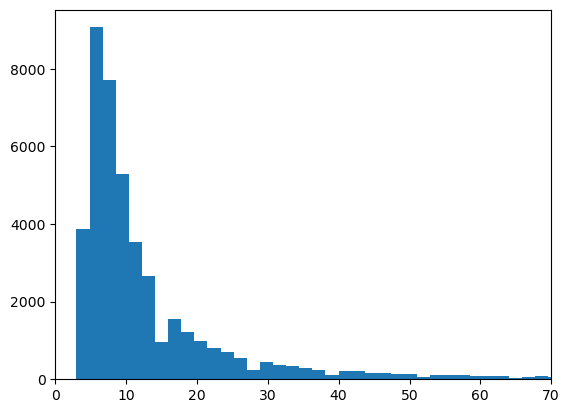

In [15]:
plt.hist(tables_good[0]["n_pixels"], 1000)
plt.xlim(0, 70)

(0.0, 70.0)

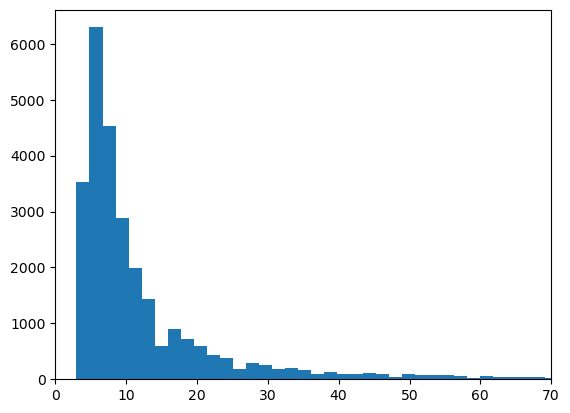

In [16]:
plt.hist(tables[0]["n_pixels"], 1000);
plt.xlim(0, 70)

In [17]:
for i in tables[0]["n_pixels"]:
    print(i)

639
4
6
63
7
6
6
1838
4
6
76
8
3
35
6
40
11
11
17
5
8
29
4
3
12
6
8
7
14
9
8
39
11
14
1837
13
5
5
10
4
5
3
9
6
10
7
20
6
23
64
15
34
10
14
10
13
7
15
7
15
35
48
6
17
8
4
6
7
6
7
70
10
5
1839
5
5
16
6
55
4
12
5
9
3
12
17
3
7
84
24
7
3
105
11
18
4
19
21
6
7
10
1838
8
29
3
22
3
7
6
5
6
5
6
12
5
15
8
9
7
15
9
5
12
9
37
17
5
6
1840
11
13
5
42
21
35
21
22
14
6
6
16
5
6
10
8
12
12
9
21
11
7
7
8
6
7
45
30
7
7
5
25
4
41
1837
5
12
37
12
16
22
3
6
7
5
21
7
12
42
12
5
6
3
50
13
7
16
3
8
17
1838
4
12
23
7
6
7
25
3
5
7
4
12
5
5
4
7
7
5
5
4
8
4
14
44
7
185
6
15
4
48
8
11
1838
9
15
14
61
7
6
3
5
16
7
7
17
37
11
10
7
7
5
6
7
11
15
14
9
8
7
14
76
5
4
6
46
8
11
6
18
9
9
27
1838
7
7
11
4
4
10
10
13
3
7
6
5
11
5
9
12
4
19
20
8
8
8
6
8
4
4
28
8
5
12
19
47
18
9
9
14
8
8
1838
5
5
18
5
12
22
5
4
13
23
7
23
7
12
13
29
6
18
3
6
5
10
11
14
6
26
19
6
6
6
1838
3
5
37
21
7
8
6
21
11
5
166
10
4
31
6
13
5
3
29
11
3
21
8
55
5
8
14
5
8
25
5
1838
8
5
13
11
6
3
68
13
5
7
9
5
12
57
6
5
5
11
9
10
4
6
9
6
9
7
19
29
105
1838


In [18]:
bins_nn = np.logspace(np.log10(2), np.log10(1855), 50)

hist_nnpix  = []
for scale in scales:
    ext = f"_scaled{scale:.4f}" if scale != 1.0 else ""
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_bad:05}.{0:04}{ext}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 

    counts_npix, _ = np.histogram(table["n_pixels"], bins=bins_nn)
    rates_npix = counts_npix / float(datacheck["corrected_elapsed_time"].iloc[0])

    hist_nnpix.append(rates_npix)
    
hist_good_nnpix, _ = np.histogram(tables[0]["n_pixels"], bins=bins_nn)

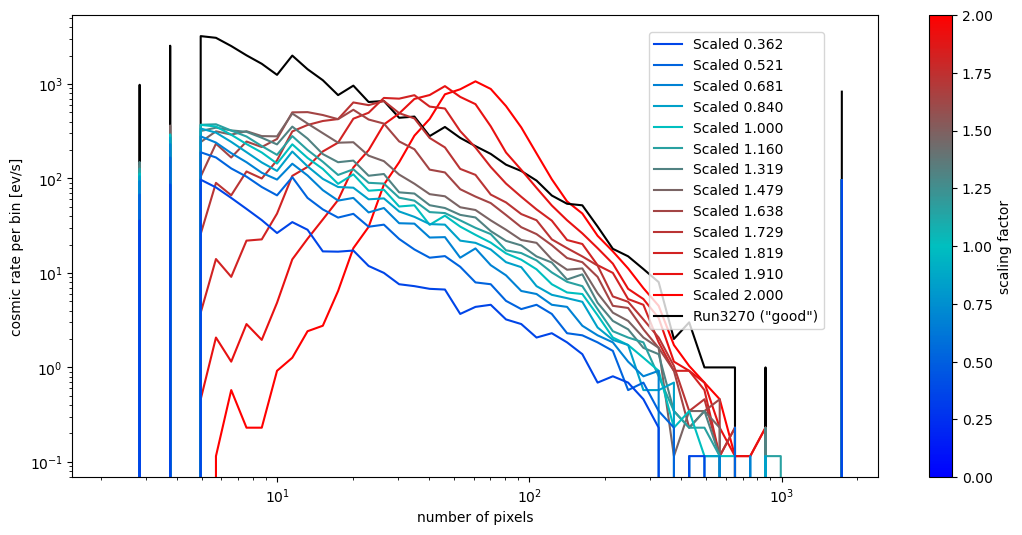

In [19]:
fig, (ax) = plt.subplots(figsize=(13,6))

pcols = ["b", "c", "r"]
colors = aux.get_colors_multiplot(scales, COLORS=pcols, ran=[0, 2])
cmap   = aux.create_cmap(pcols)
aux.plot_colorbar(fig, ax, [0, 2], cmap, label="scaling factor")

for i, scale in enumerate(scales):
    ax.plot(bins_nn[1:]/2+bins_nn[:-1]/2, hist_nnpix[i], color=colors[i], label=f"Scaled {scale:.3f}", zorder=-i,)

ax.plot(bins_nn[1:]/2+bins_nn[:-1]/2, hist_good_nnpix, color="k", zorder=-i, label=f"Run{run_good} (\"good\")")

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(0, 250)
ax.legend(loc=(0.715, 0.32))
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("number of pixels")

# plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()